In [1]:
import numpy as np
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline,splrep, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import empymod
import discretize
import  os

In [2]:
import torch
import torch.nn.functional as F
from torch.autograd.functional import jacobian
eps = torch.finfo(torch.float32).eps
print(eps)

1.1920928955078125e-07


In [3]:
from masa_utils import PsuedoLog
from masa_utils_pytorch import InducedPolarizationSimulation
from masa_utils_pytorch import Pelton, Debye_Sum_Ser_f
from masa_utils_pytorch import Optimization

# multiple reference models Pelton model

In [4]:
# low time constant 
tau_true=0.1
parm_true = torch.tensor([np.log(0.2), 0.50, np.log(tau_true), 0.5], dtype=torch.float) #, requires_grad=False)
# inital reference model
np_mvec_true = parm_true.detach().numpy()

parm_ref1 = torch.tensor([np.log(0.22), 0.1, np.log(0.05), 0.6], dtype=torch.float, requires_grad=True) #, requires_grad=False)
parm_ref2 = torch.tensor([np.log(0.22), 0.1, np.log(0.2), 0.6], dtype=torch.float, requires_grad=True) #, requires_grad=False)
parm_ref3 = torch.tensor([np.log(0.22), 0.1, np.log(0.05), 0.4], dtype=torch.float, requires_grad=True) #, requires_grad=False)
parm_ref4 = torch.tensor([np.log(0.22), 0.1, np.log(0.2), 0.4], dtype=torch.float, requires_grad=True) #, requires_grad=False)

nref= 4
parm_ref = [parm_ref1, parm_ref2, parm_ref3, parm_ref4]

# Define Spectrum IP

In [5]:
nfreq = 71
freqstrt_log = -2
freqend_log = 5
freq = np.logspace(-2, 5, nfreq)

freq_plot = freq
print(freq.shape)
print(freq)

(71,)
[1.00000000e-02 1.25892541e-02 1.58489319e-02 1.99526231e-02
 2.51188643e-02 3.16227766e-02 3.98107171e-02 5.01187234e-02
 6.30957344e-02 7.94328235e-02 1.00000000e-01 1.25892541e-01
 1.58489319e-01 1.99526231e-01 2.51188643e-01 3.16227766e-01
 3.98107171e-01 5.01187234e-01 6.30957344e-01 7.94328235e-01
 1.00000000e+00 1.25892541e+00 1.58489319e+00 1.99526231e+00
 2.51188643e+00 3.16227766e+00 3.98107171e+00 5.01187234e+00
 6.30957344e+00 7.94328235e+00 1.00000000e+01 1.25892541e+01
 1.58489319e+01 1.99526231e+01 2.51188643e+01 3.16227766e+01
 3.98107171e+01 5.01187234e+01 6.30957344e+01 7.94328235e+01
 1.00000000e+02 1.25892541e+02 1.58489319e+02 1.99526231e+02
 2.51188643e+02 3.16227766e+02 3.98107171e+02 5.01187234e+02
 6.30957344e+02 7.94328235e+02 1.00000000e+03 1.25892541e+03
 1.58489319e+03 1.99526231e+03 2.51188643e+03 3.16227766e+03
 3.98107171e+03 5.01187234e+03 6.30957344e+03 7.94328235e+03
 1.00000000e+04 1.25892541e+04 1.58489319e+04 1.99526231e+04
 2.51188643e+04 3.

In [6]:
IP_model = Pelton(freq=freq)
sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")


In [7]:
dobs_clean=sim.dpred(parm_true).detach()
f_abs = abs(IP_model.f(parm_true)).detach().numpy()
print(f_abs.max(),f_abs.min())
relative_error = torch.tensor(0.02)

noise_floor = torch.tensor(f_abs.max() * 1e-3)
torch.random.seed()
dobs =  dobs_clean + torch.rand(len(dobs_clean)) * torch.sqrt(
        (relative_error * abs(dobs_clean))**2 
        + (noise_floor*torch.ones(len(dobs_clean)))**2
    )

0.19449106 0.10028248


In [8]:
opt = Optimization(sim=sim, dobs=dobs)
Wd =opt.get_Wd(ratio=relative_error, plateau=noise_floor)
# opt.Wd = torch.diag(torch.ones(len(dobs)))
opt.Ws = torch.eye(4)

In [9]:
print(torch.diag(opt.Wd))

tensor([ 251.8446,  255.7257,  255.5102,  255.4819,  256.7382,  261.9091,
         262.8217,  263.5677,  263.9172,  265.9987,  272.1174,  275.2302,
         277.1232,  278.3196,  281.2267,  289.7294,  293.9317,  294.6111,
         300.2781,  306.9062,  313.5776,  322.3177,  329.6443,  335.0356,
         342.6854,  351.6903,  359.3743,  368.8885,  379.9070,  382.8429,
         392.7439,  398.9914,  404.8209,  413.2628,  419.5228,  428.0486,
         435.6435,  438.4430,  443.3719,  449.0926,  449.6862,  458.2701,
         456.9881,  468.4390,  469.9684,  472.3981,  469.2417,  470.9915,
         471.8478,  473.5678,  479.1822,  476.6824,  480.9551,  487.2607,
         480.2821,  486.3820,  487.5440,  486.6866,  491.5637,  487.7342,
         489.4754,  487.2189,  491.4209,  485.6029,  488.0548,  493.7598,
         489.5664,  486.3472,  490.9377,  490.5250,  492.9044, 4575.9551,
        4482.7812, 4365.8145, 4233.6743, 4100.2798, 3946.7961, 3804.5957,
        3642.7842, 3466.9563, 3359.824

In [10]:
niter = 80
stol=1e-6
coolingFactor = 2.0
coolingRate = 2
mu=1e-3
beta0_ratio = 1

In [11]:
models_rec = []
dpreds = []
errors_prg = []
models_prg = []
dinit_refs = []
for i in range(nref):
    parm_init = parm_ref[i]
    beta0 = opt.BetaEstimate_byEig(
        m=parm_init,norm=False, update_Wsen=True, beta0_ratio=beta0_ratio)
    print(beta0)
    mpred = opt.GradientDescent(stol=stol,l1reg=True,
    coolingFactor=coolingFactor, coolingRate=coolingRate,mu=mu,
        mvec_init=parm_init,niter=niter,beta0=beta0,
        update_Wsen=True,ELS=True, BLS=True)
    dinit_refs.append(opt.dpred(parm_init))
    models_rec.append(mpred)
    dpreds.append(opt.dpred(mpred))
    errors_prg.append(opt.error_prg)
    models_prg.append(opt.mvec_prg)


tensor(1.7044e+09)
  1, beta:1.7e+09, step:9.5e-07, gradient:3.5e+05,  f:6.3e+04
  2, beta:1.7e+09, step:9.5e-07, gradient:2.2e+09,  f:4.3e+06
  3, beta:8.5e+08, step:1.9e-06, gradient:1.1e+09,  f:6.5e+04
  4, beta:8.5e+08, step:9.5e-07, gradient:1.1e+09,  f:1.1e+06
  5, beta:4.3e+08, step:1.9e-06, gradient:5.4e+08,  f:6.4e+04
  6, beta:4.3e+08, step:9.5e-07, gradient:5.4e+08,  f:3.3e+05
  7, beta:2.1e+08, step:1.9e-06, gradient:2.7e+08,  f:6.4e+04
  8, beta:2.1e+08, step:9.5e-07, gradient:2.7e+08,  f:1.3e+05
  9, beta:1.1e+08, step:1.9e-06, gradient:1.4e+08,  f:6.3e+04
 10, beta:1.1e+08, step:9.5e-07, gradient:1.3e+08,  f:7.8e+04
 11, beta:5.3e+07, step:1.9e-06, gradient:6.8e+07,  f:6.3e+04
 12, beta:5.3e+07, step:9.5e-07, gradient:6.7e+07,  f:6.6e+04
 13, beta:2.7e+07, step:1.9e-06, gradient:3.4e+07,  f:6.3e+04
 14, beta:2.7e+07, step:9.5e-07, gradient:3.3e+07,  f:6.3e+04
 15, beta:1.3e+07, step:1.9e-06, gradient:1.7e+07,  f:6.3e+04
 16, beta:1.3e+07, step:9.5e-07, gradient:1.6e+07, 

In [12]:
print( "Parameter:     res0,   chg,       tau,     c")

for i in range(nref):
    np_mvec_ref = parm_ref[i].detach().numpy()
    np_mvec_est = models_rec[i].detach().numpy()
    print(f"ref{i+1}     & {np.exp(np_mvec_ref[0]):.2e} & {np_mvec_ref[1]:.3f} & {np.exp(np_mvec_ref[2]):.2e} & {np_mvec_ref[3]:.3f}")
    print(f"est{i+1}     & {np.exp(np_mvec_est[0]):.2e} & { np_mvec_est[1]:.3f} & { np.exp(np_mvec_est[2]):.2e} & { np_mvec_est[3]:.3f}")
print(f"true     & {np.exp(np_mvec_true[0]):.2e} & {np_mvec_true[1]:.3f} & {np.exp(np_mvec_true[2]):.2e} & {np_mvec_true[3]:.3f}")

Parameter:     res0,   chg,       tau,     c
ref1     & 2.20e-01 & 0.100 & 5.00e-02 & 0.600
est1     & 2.00e-01 & 0.494 & 9.24e-02 & 0.505
ref2     & 2.20e-01 & 0.100 & 2.00e-01 & 0.600
est2     & 2.00e-01 & 0.493 & 9.83e-02 & 0.503
ref3     & 2.20e-01 & 0.100 & 5.00e-02 & 0.400
est3     & 2.00e-01 & 0.493 & 1.00e-01 & 0.502
ref4     & 2.20e-01 & 0.100 & 2.00e-01 & 0.400
est4     & 2.00e-01 & 0.493 & 9.89e-02 & 0.502
true     & 2.00e-01 & 0.500 & 1.00e-01 & 0.500


In [13]:
dest_abs_np =[]
dest_phase_np =[]
dest_real_np =[]
dest_imag_np =[]
dinit_abs_np =[]
dinit_phase_np =[]
for i in range(nref):
    dest = dpreds[i].detach().numpy()
    dinit = dinit_refs[i].detach().numpy()
    dest_real = dest[:nfreq]
    dest_imag = dest[nfreq:]
    dinit_real = dinit[:nfreq]
    dinit_imag = dinit[nfreq:]
    dest_abs = np.abs(dest_real + 1j * dest_imag)
    dest_phase = np.angle(dest_real + 1j * dest_imag, deg=True)
    dinit_abs = np.abs(dinit_real + 1j * dinit_imag) 
    dinit_phase = np.angle(dinit_real + 1j * dinit_imag, deg=True)
    dest_real_np.append(dest_real)
    dest_imag_np.append(dest_imag)
    dest_abs_np.append(dest_abs)
    dest_phase_np.append(dest_phase)
    dinit_abs_np.append(dinit_abs)
    dinit_phase_np.append(dinit_phase)
dobs_np = dobs.detach().numpy()
dobs_real = dobs_np[:nfreq]
dobs_imag = dobs_np[nfreq:]
dobs_abs = np.abs(dobs_real + 1j * dobs_imag)
dobs_phase = np.angle(dobs_real + 1j * dobs_imag, deg=True)


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


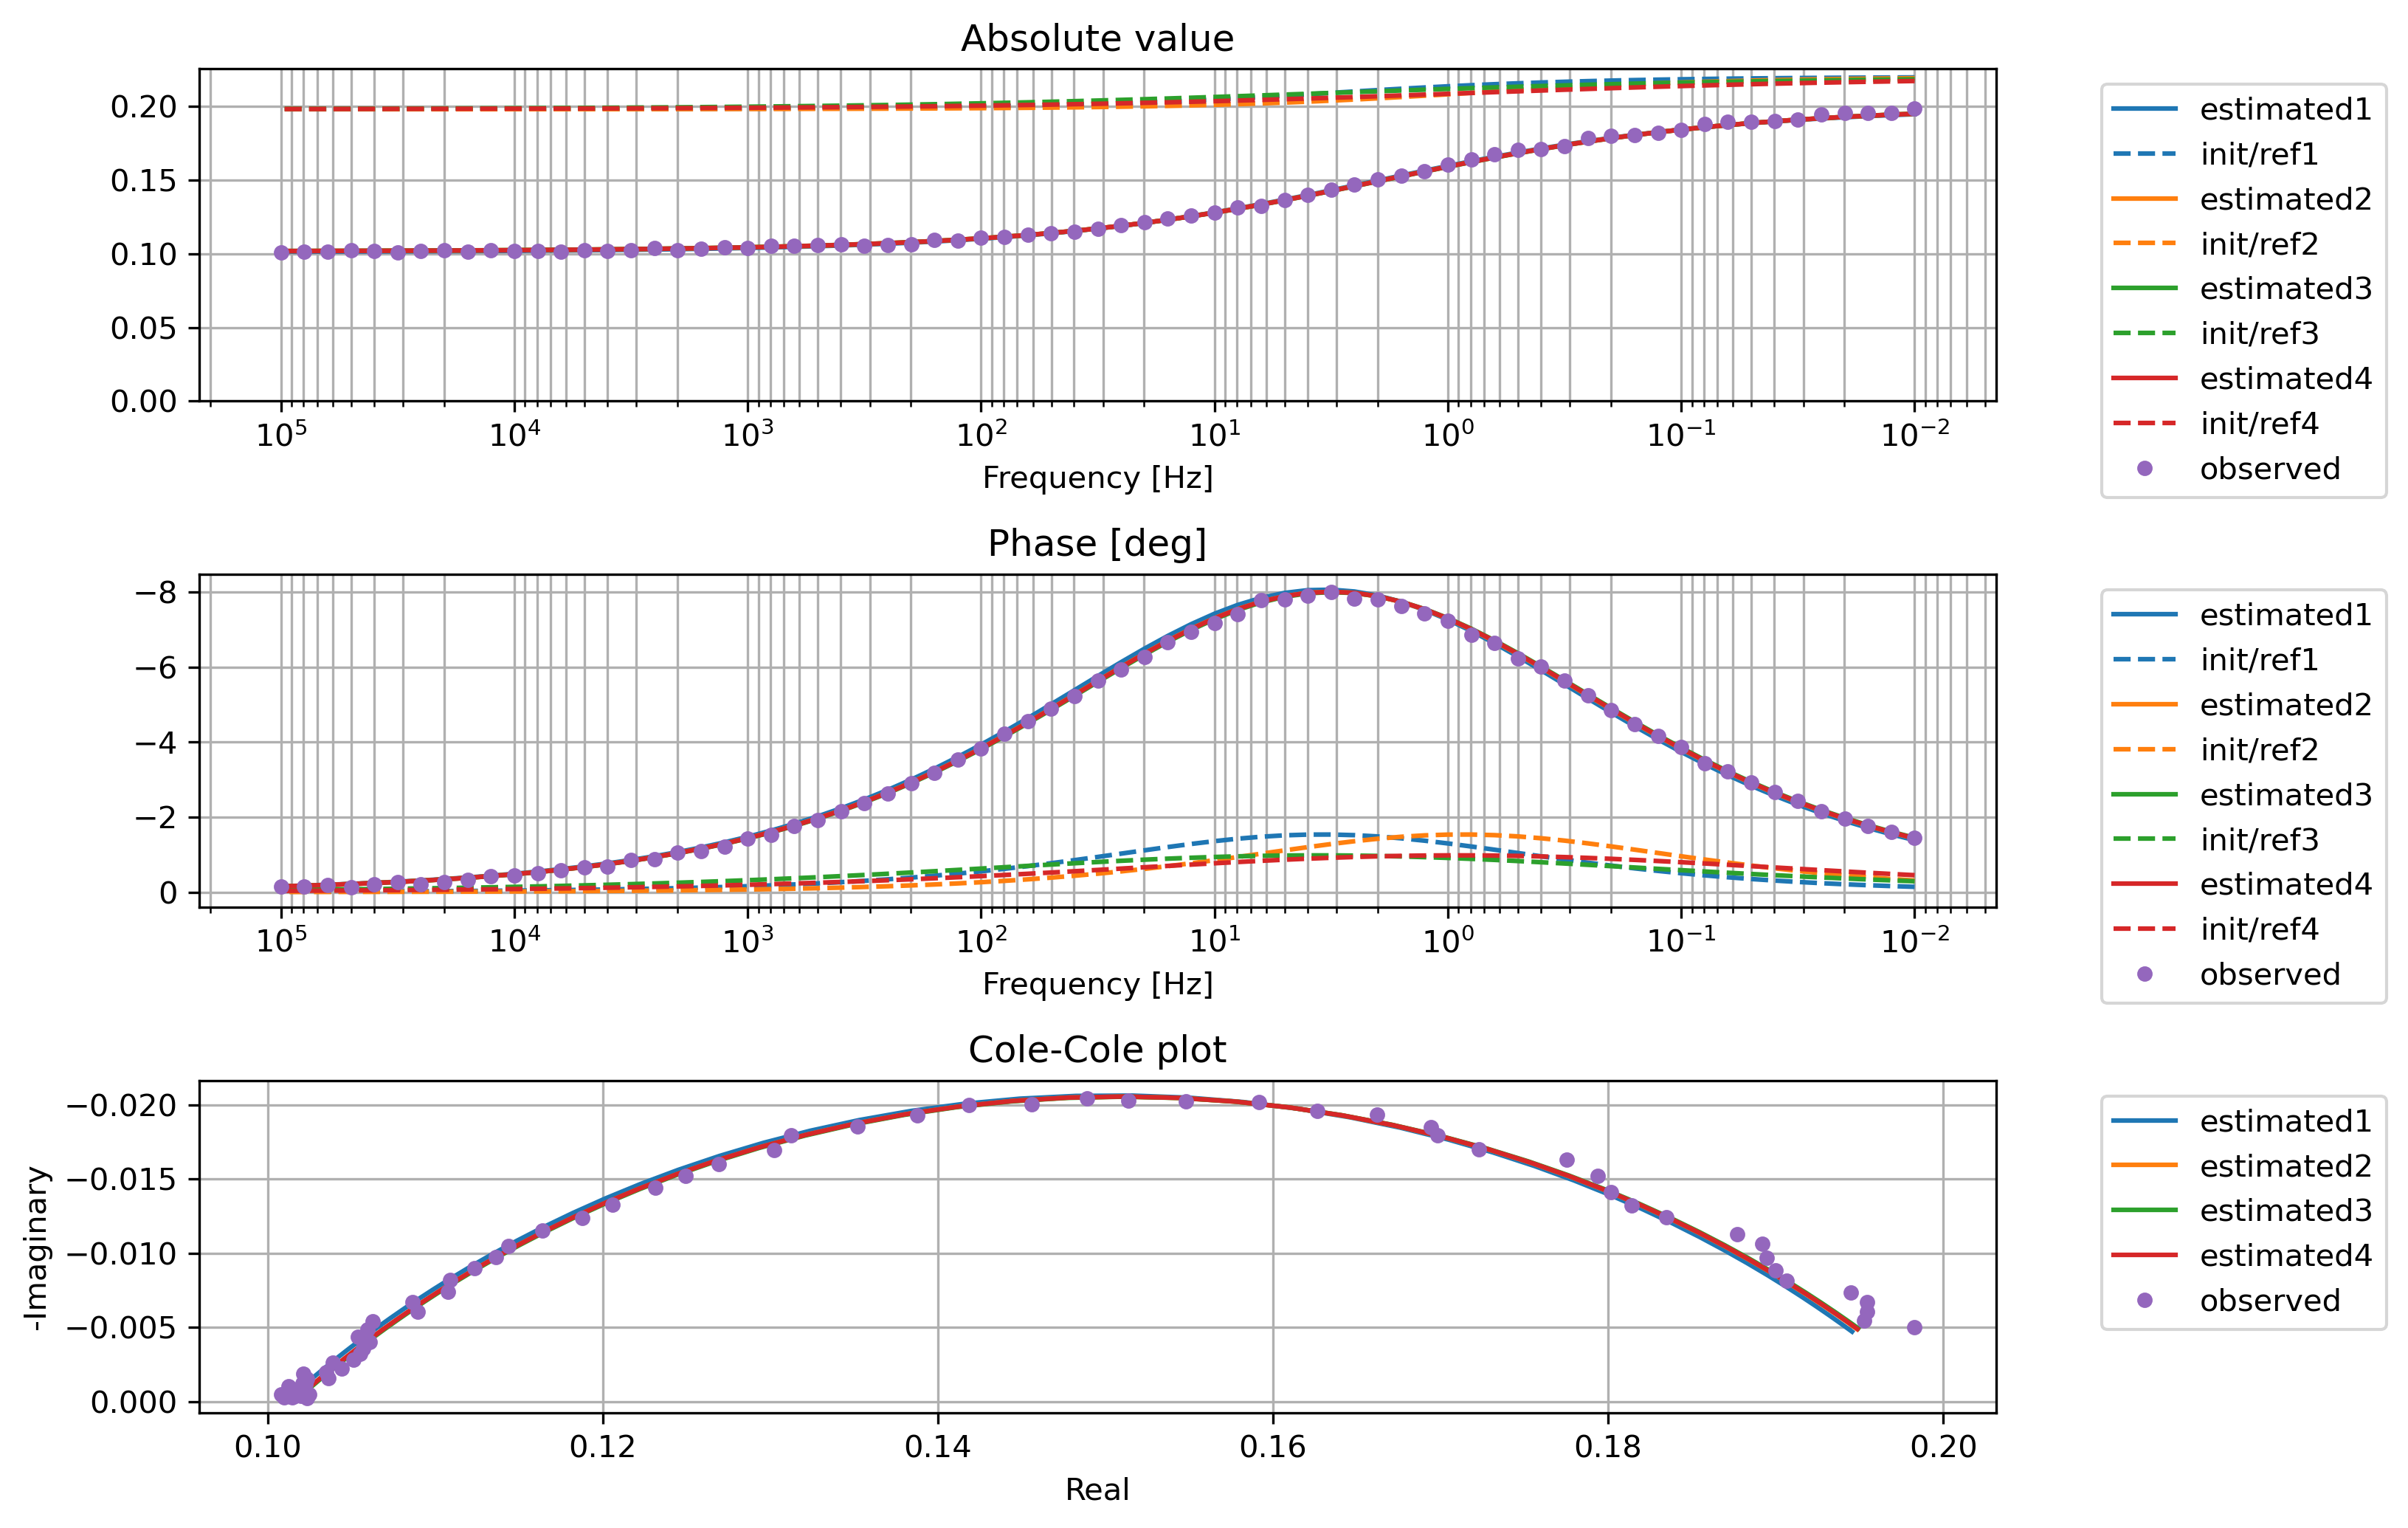

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(11,7),dpi=300)
for i in range(nref):
    dest_abs = dest_abs_np[i]
    dest_phase = dest_phase_np[i]
    dest_real = dest_real_np[i]
    dest_imag = dest_imag_np[i]
    dinit_abs = dinit_abs_np[i] 
    dinit_phase = dinit_phase_np[i]
    ax[0].semilogx(freq_plot, dest_abs, color=f"C{i}", label=f"estimated{i+1}")
    ax[0].semilogx(freq_plot, dinit_abs, color=f"C{i}", linestyle="--", label=f"init/ref{i+1}")
    ax[1].semilogx(freq_plot, dest_phase, color=f"C{i}", label=f"estimated{i+1}")
    ax[1].semilogx(freq_plot, dinit_phase, color=f"C{i}", linestyle="--", label=f"init/ref{i+1}")
    ax[2].plot(dest_real, dest_imag, color=f"C{i}", label=f"estimated{i+1}")
ax[0].semilogx(freq_plot, dobs_abs, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="observed")
ax[0].set_ylim(bottom=0)
ax[0].invert_xaxis()
ax[1].semilogx(freq_plot, dobs_phase, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="observed")
ax[1].invert_yaxis()
ax[1].invert_xaxis()
ax[2].plot(dobs_real, dobs_imag, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="observed")
ax[2].invert_yaxis()
for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_title("Absolute value")
ax[1].set_title("Phase [deg]")
ax[2].set_title("Cole-Cole plot")
ax[2].set_xlabel("Real")
ax[2].set_ylabel("-Imaginary")
plt.tight_layout()
plt.savefig("42_Pelton_res_sip.jpg", dpi=300)

In [15]:
U_pelton = []
S_pelton=[]
S_pelton_norm = []
V_pelton=[]
for i in range(nref):
    J_np = opt.J(models_rec[i]).detach().numpy()
    U, S, V = np.linalg.svd(J_np, full_matrices=False)
    U_pelton.append(U)
    S_pelton.append(S)
    s_norm = S/S.max()
    S_pelton_norm.append(s_norm)
    V_pelton.append(V)


# Debye Combination Series Config

In [16]:
taus_cmb = []
parm_ref = []
# ntau_cmb = [4, 7, 8, 15]
# taus_strt = [-3, -3, -5, -5]
# taus_end = [0, 0 , 2, 2]
ntau_cmb = [15 ,8 , 11, 6 ]
taus_strt = [-5,-5,-4, -4 ]
taus_end = [2,2,1, 1 ]

for i in range(nref):
    ntau = ntau_cmb[i]
    taus=np.logspace(taus_strt[i], taus_end[i], ntau_cmb[i])
    parm_init = torch.tensor(
    # np.r_[np.log(0.2), 0.01*np.ones(ntau)],
    np.r_[np.log(0.22), np.zeros(ntau)],
    dtype=torch.float32,
    requires_grad=True
    ) #, requires_grad=False)

    print(taus) 
    taus_cmb.append(taus)
    parm_ref.append(parm_init)


[1.00000000e-05 3.16227766e-05 1.00000000e-04 3.16227766e-04
 1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01 3.16227766e+01 1.00000000e+02]
[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]
[1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01]
[1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01]


In [17]:
models_rec = []
dpreds = []
errors_prg = []
models_prg = []
dinit_refs = []
for i in range(nref):
    parm_init = parm_ref[i]
    IP_model = Debye_Sum_Ser_f(freq=freq, taus=taus_cmb[i])
    sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")
    opt = Optimization(sim=sim, dobs=dobs)
    Wd =opt.get_Wd(ratio=relative_error, plateau=noise_floor)
    opt.Ws = torch.eye(len(parm_init))
    beta0 = opt.BetaEstimate_byEig(
    m=parm_init,norm=False, update_Wsen=True, beta0_ratio=beta0_ratio)
    print(beta0)
    mpred = opt.GradientDescent(stol=stol,l1reg=True,
    coolingFactor=coolingFactor, coolingRate=coolingRate,mu=mu,
        mvec_init=parm_init,niter=niter,beta0=beta0,
        update_Wsen=True,ELS=True, BLS=True)
    dinit_refs.append(opt.dpred(parm_init))
    models_rec.append(mpred)
    dpreds.append(opt.dpred(mpred))
    errors_prg.append(opt.error_prg)
    models_prg.append(opt.mvec_prg)


tensor(54388328.)
  1, beta:5.4e+07, step:9.5e-07, gradient:1.3e+06,  f:9.7e+04
  2, beta:5.4e+07, step:3.8e-06, gradient:1.7e+08,  f:9.7e+04
  3, beta:2.7e+07, step:9.5e-07, gradient:1.2e+07,  f:9.8e+04
  4, beta:2.7e+07, step:6.1e-05, gradient:8.3e+07,  f:9.8e+04
  5, beta:1.4e+07, step:9.5e-07, gradient:5.9e+06,  f:9.7e+04
  6, beta:1.4e+07, step:6.1e-05, gradient:4.1e+07,  f:9.7e+04
  7, beta:6.8e+06, step:9.5e-07, gradient:3.5e+06,  f:9.7e+04
  8, beta:6.8e+06, step:6.1e-05, gradient:2.0e+07,  f:9.7e+04
  9, beta:3.4e+06, step:9.5e-07, gradient:1.8e+06,  f:9.7e+04
 10, beta:3.4e+06, step:1.2e-04, gradient:9.3e+06,  f:9.7e+04
 11, beta:1.7e+06, step:9.5e-07, gradient:1.6e+06,  f:9.7e+04
 12, beta:1.7e+06, step:6.1e-05, gradient:4.2e+06,  f:9.7e+04
 13, beta:8.5e+05, step:9.5e-07, gradient:1.3e+06,  f:9.7e+04
 14, beta:8.5e+05, step:2.4e-04, gradient:1.6e+06,  f:9.7e+04
 15, beta:4.2e+05, step:1.2e-01, gradient:1.3e+06,  f:9.6e+04
 16, beta:4.2e+05, step:1.0e+00, gradient:6.2e+05,  

In [18]:
print( "Parameter:     res0,   chg")
np_mvec_refs= []
np_mvec_ests= []
for i in range(nref):
    np_mvec_ref = parm_ref[i].detach().numpy()
    np_mvec_est = models_rec[i].detach().numpy()
    np_mvec_refs.append(np_mvec_ref)
    np_mvec_ests.append(np_mvec_est)
    print(f"ref{i+1}     & {np.exp(np_mvec_ref[0]):.2e} & {np_mvec_ref[1:].sum():.3f} ")
    print(f"est{i+1}     & {np.exp(np_mvec_est[0]):.2e} & { np_mvec_est[1:].sum():.3f}")
print(f"true     & {np.exp(np_mvec_true[0]):.2e} & {np_mvec_true[1]:.3f} & {np.exp(np_mvec_true[2]):.2e} & {np_mvec_true[3]:.3f}")

Parameter:     res0,   chg
ref1     & 2.20e-01 & 0.000 
est1     & 2.08e-01 & 0.509
ref2     & 2.20e-01 & 0.000 
est2     & 2.07e-01 & 0.507
ref3     & 2.20e-01 & 0.000 
est3     & 1.97e-01 & 0.481
ref4     & 2.20e-01 & 0.000 
est4     & 1.97e-01 & 0.481
true     & 2.00e-01 & 0.500 & 1.00e-01 & 0.500


In [19]:
dest_abs_np =[]
dest_phase_np =[]
dest_real_np =[]
dest_imag_np =[]
dinit_abs_np =[]
dinit_phase_np =[]
for i in range(nref):
    dest = dpreds[i].detach().numpy()
    dinit = dinit_refs[i].detach().numpy()
    dest_real = dest[:nfreq]
    dest_imag = dest[nfreq:]
    dinit_real = dinit[:nfreq]
    dinit_imag = dinit[nfreq:]
    dest_abs = np.abs(dest_real + 1j * dest_imag)
    dest_phase = np.angle(dest_real + 1j * dest_imag, deg=True)
    dinit_abs = np.abs(dinit_real + 1j * dinit_imag) 
    dinit_phase = np.angle(dinit_real + 1j * dinit_imag, deg=True)
    dest_real_np.append(dest_real)
    dest_imag_np.append(dest_imag)
    dest_abs_np.append(dest_abs)
    dest_phase_np.append(dest_phase)
    dinit_abs_np.append(dinit_abs)
    dinit_phase_np.append(dinit_phase)
dobs_np = dobs.detach().numpy()
dobs_real = dobs_np[:nfreq]
dobs_imag = dobs_np[nfreq:]
dobs_abs = np.abs(dobs_real + 1j * dobs_imag)
dobs_phase = np.angle(dobs_real + 1j * dobs_imag, deg=True)


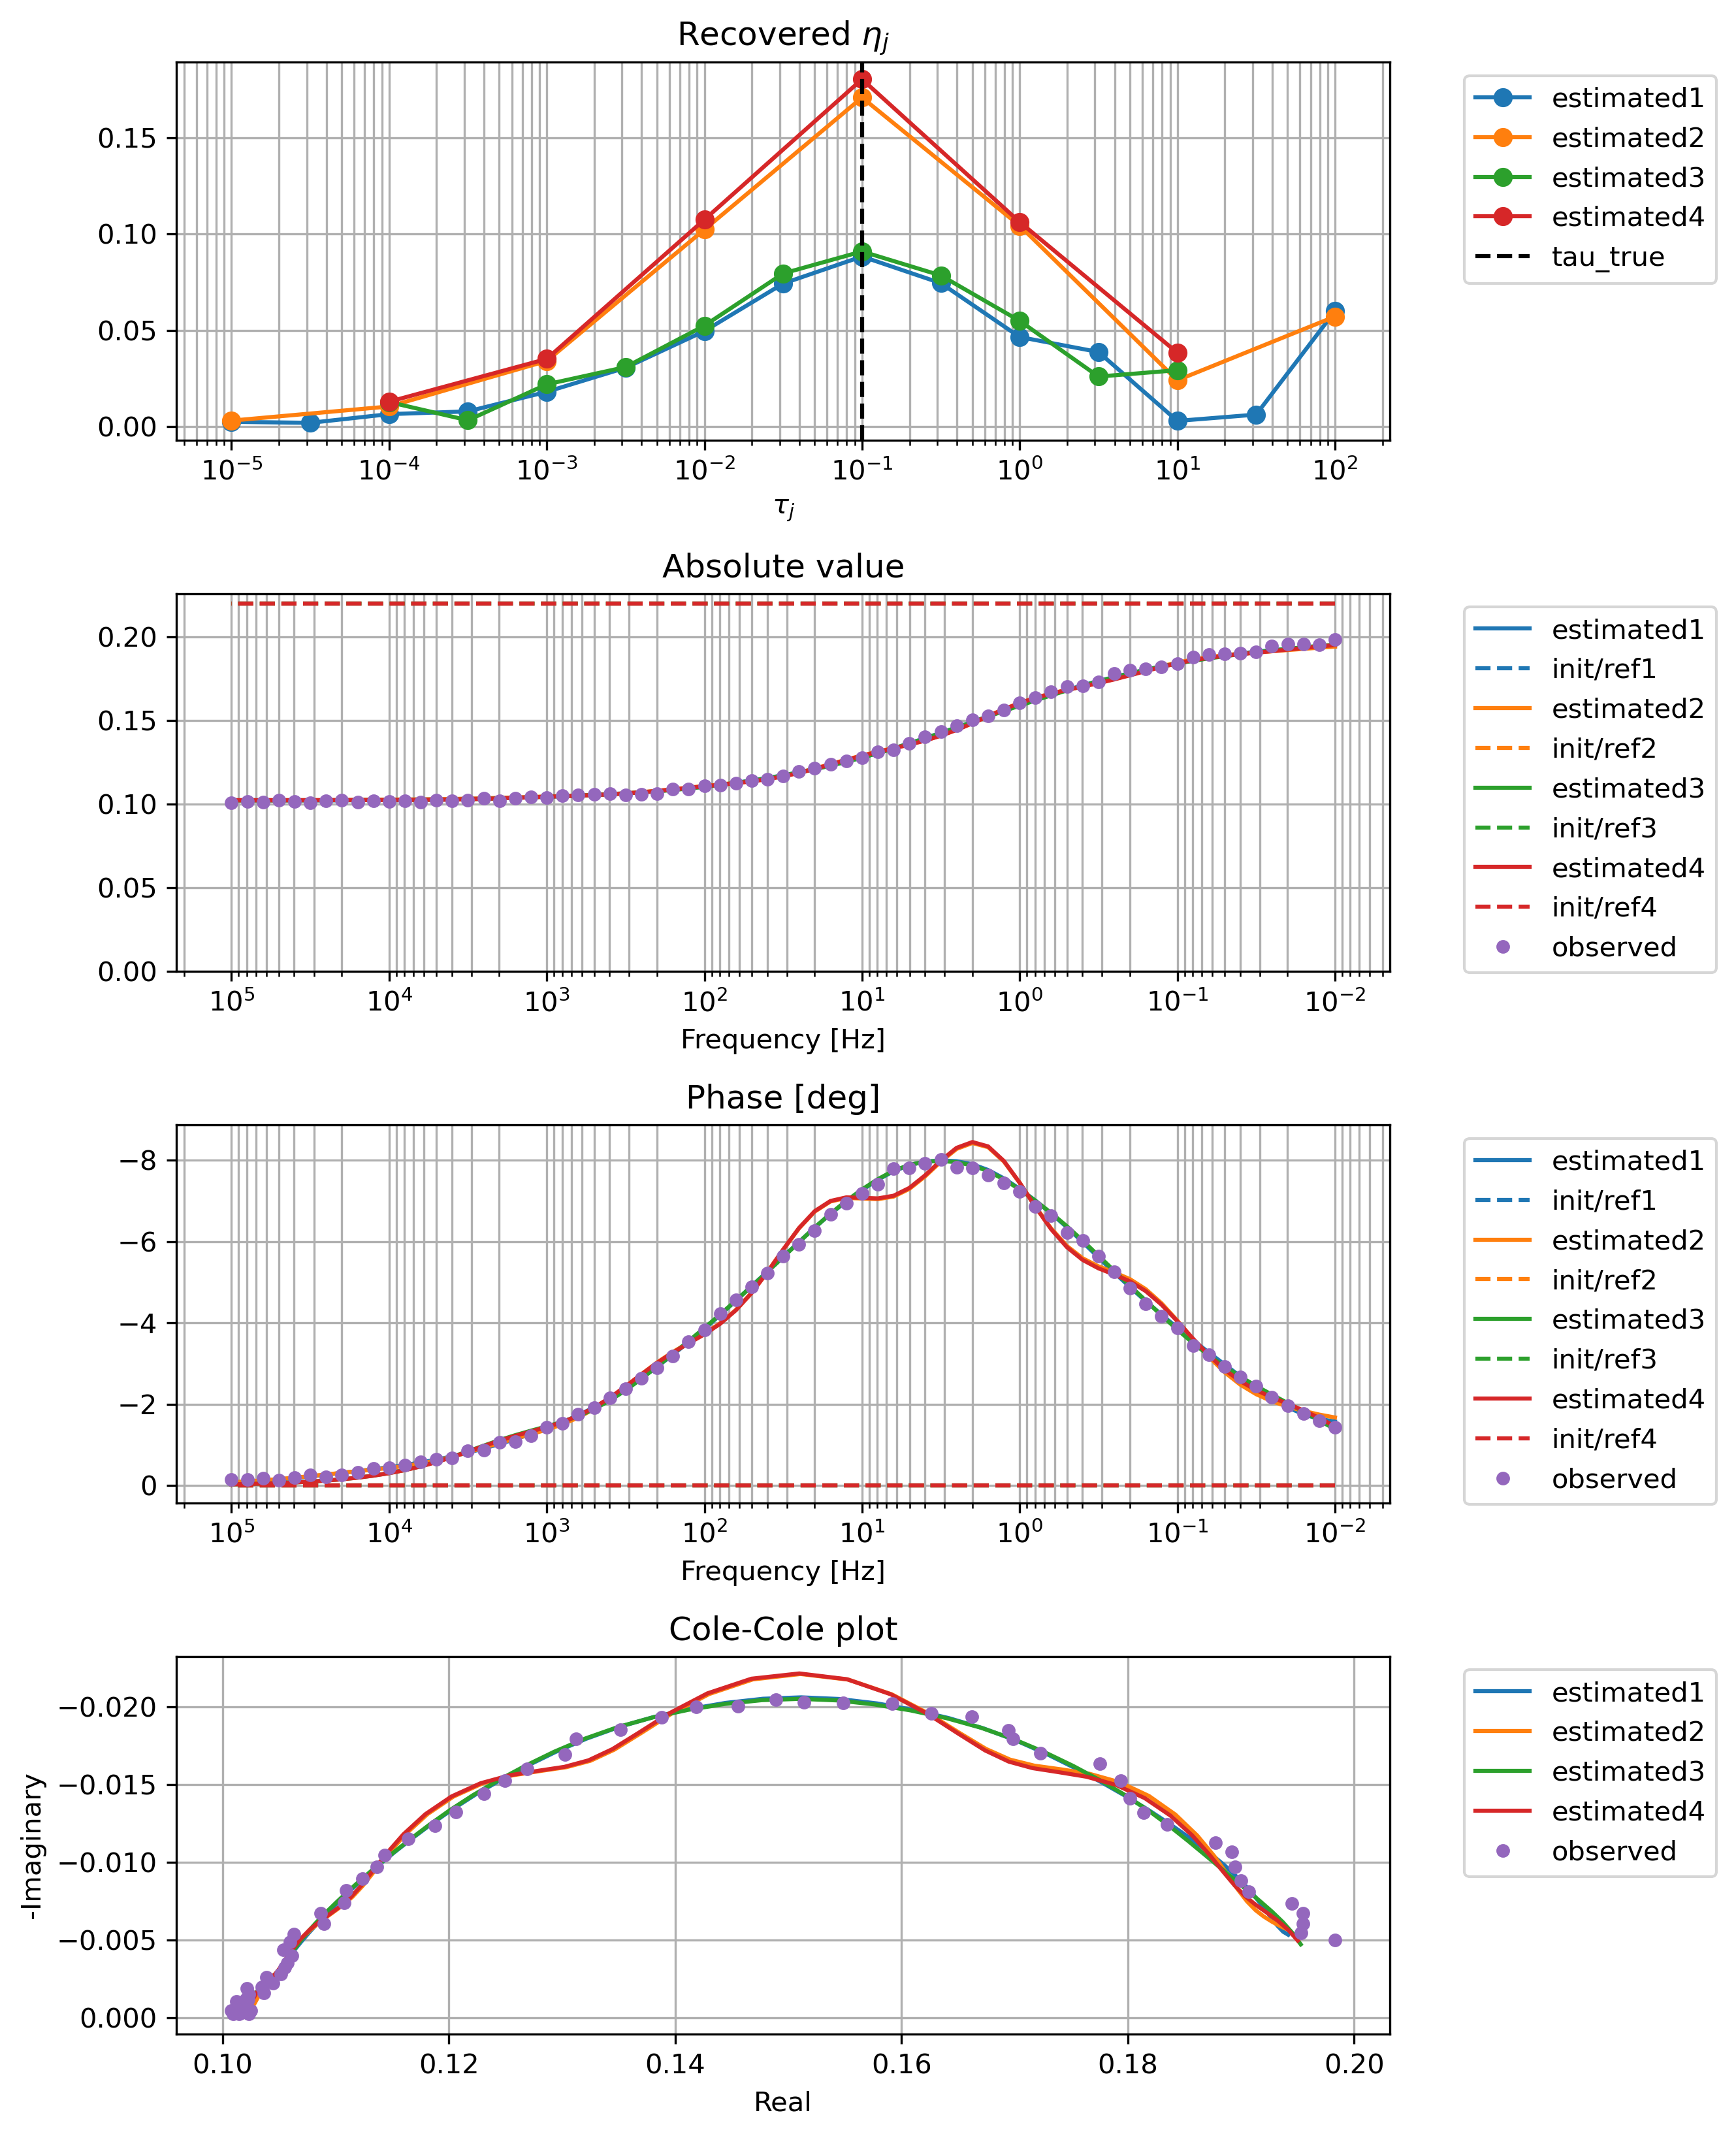

In [20]:
fig, ax = plt.subplots(4, 1, figsize=(9,11),dpi=300)
for i in range(nref):
    dest_abs = dest_abs_np[i]
    dest_phase = dest_phase_np[i]
    dest_real = dest_real_np[i]
    dest_imag = dest_imag_np[i]
    dinit_abs = dinit_abs_np[i] 
    dinit_phase = dinit_phase_np[i]
    np_mvec_est = models_rec[i].detach().numpy()
    taus = taus_cmb[i]
    ax[0].semilogx(taus, np_mvec_est[1:], color=f"C{i}", marker="o", label=f"estimated{i+1}")
    ax[1].semilogx(freq_plot, dest_abs, color=f"C{i}", label=f"estimated{i+1}")
    ax[1].semilogx(freq_plot, dinit_abs, color=f"C{i}", linestyle="--", label=f"init/ref{i+1}")
    ax[2].semilogx(freq_plot, dest_phase, color=f"C{i}", label=f"estimated{i+1}")
    ax[2].semilogx(freq_plot, dinit_phase, color=f"C{i}", linestyle="--", label=f"init/ref{i+1}")
    ax[3].plot(dest_real, dest_imag, color=f"C{i}", label=f"estimated{i+1}")
ax[0].axvline(x=tau_true, color="k", linestyle="--", label="tau_true")
ax[1].semilogx(freq_plot, dobs_abs, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="observed")
ax[1].set_ylim(bottom=0)
ax[1].invert_xaxis()
ax[2].semilogx(freq_plot, dobs_phase, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="observed")
ax[3].plot(dobs_real, dobs_imag, color=f"C{nref}", linestyle="",markersize=4.0, marker="o", label="observed")
ax[2].invert_xaxis()
ax[2].invert_yaxis()
ax[3].invert_yaxis()
for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_title(r"Recovered $\eta_j$")
ax[0].set_xlabel(r"$\tau_j$")
ax[1].set_title("Absolute value")
ax[2].set_title("Phase [deg]")
ax[3].set_title("Cole-Cole plot")
ax[3].set_xlabel("Real")
ax[3].set_ylabel("-Imaginary")
plt.tight_layout()
plt.savefig("42_Debye_Sum_sip.jpg", dpi=300)

In [21]:
index =3
IP_model = Debye_Sum_Ser_f(freq=freq, taus=taus_cmb[index])
sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")
mpred = models_rec[index]
ntau = ntau_cmb[index]
taus = taus_cmb[index]
jacobian = sim.J(mpred)
j_plot_real = jacobian[:nfreq].detach().numpy()
j_plot_imag = jacobian[nfreq:].detach().numpy()
print(j_plot_imag.shape)
print(j_plot_real.shape)

(71, 7)
(71, 7)


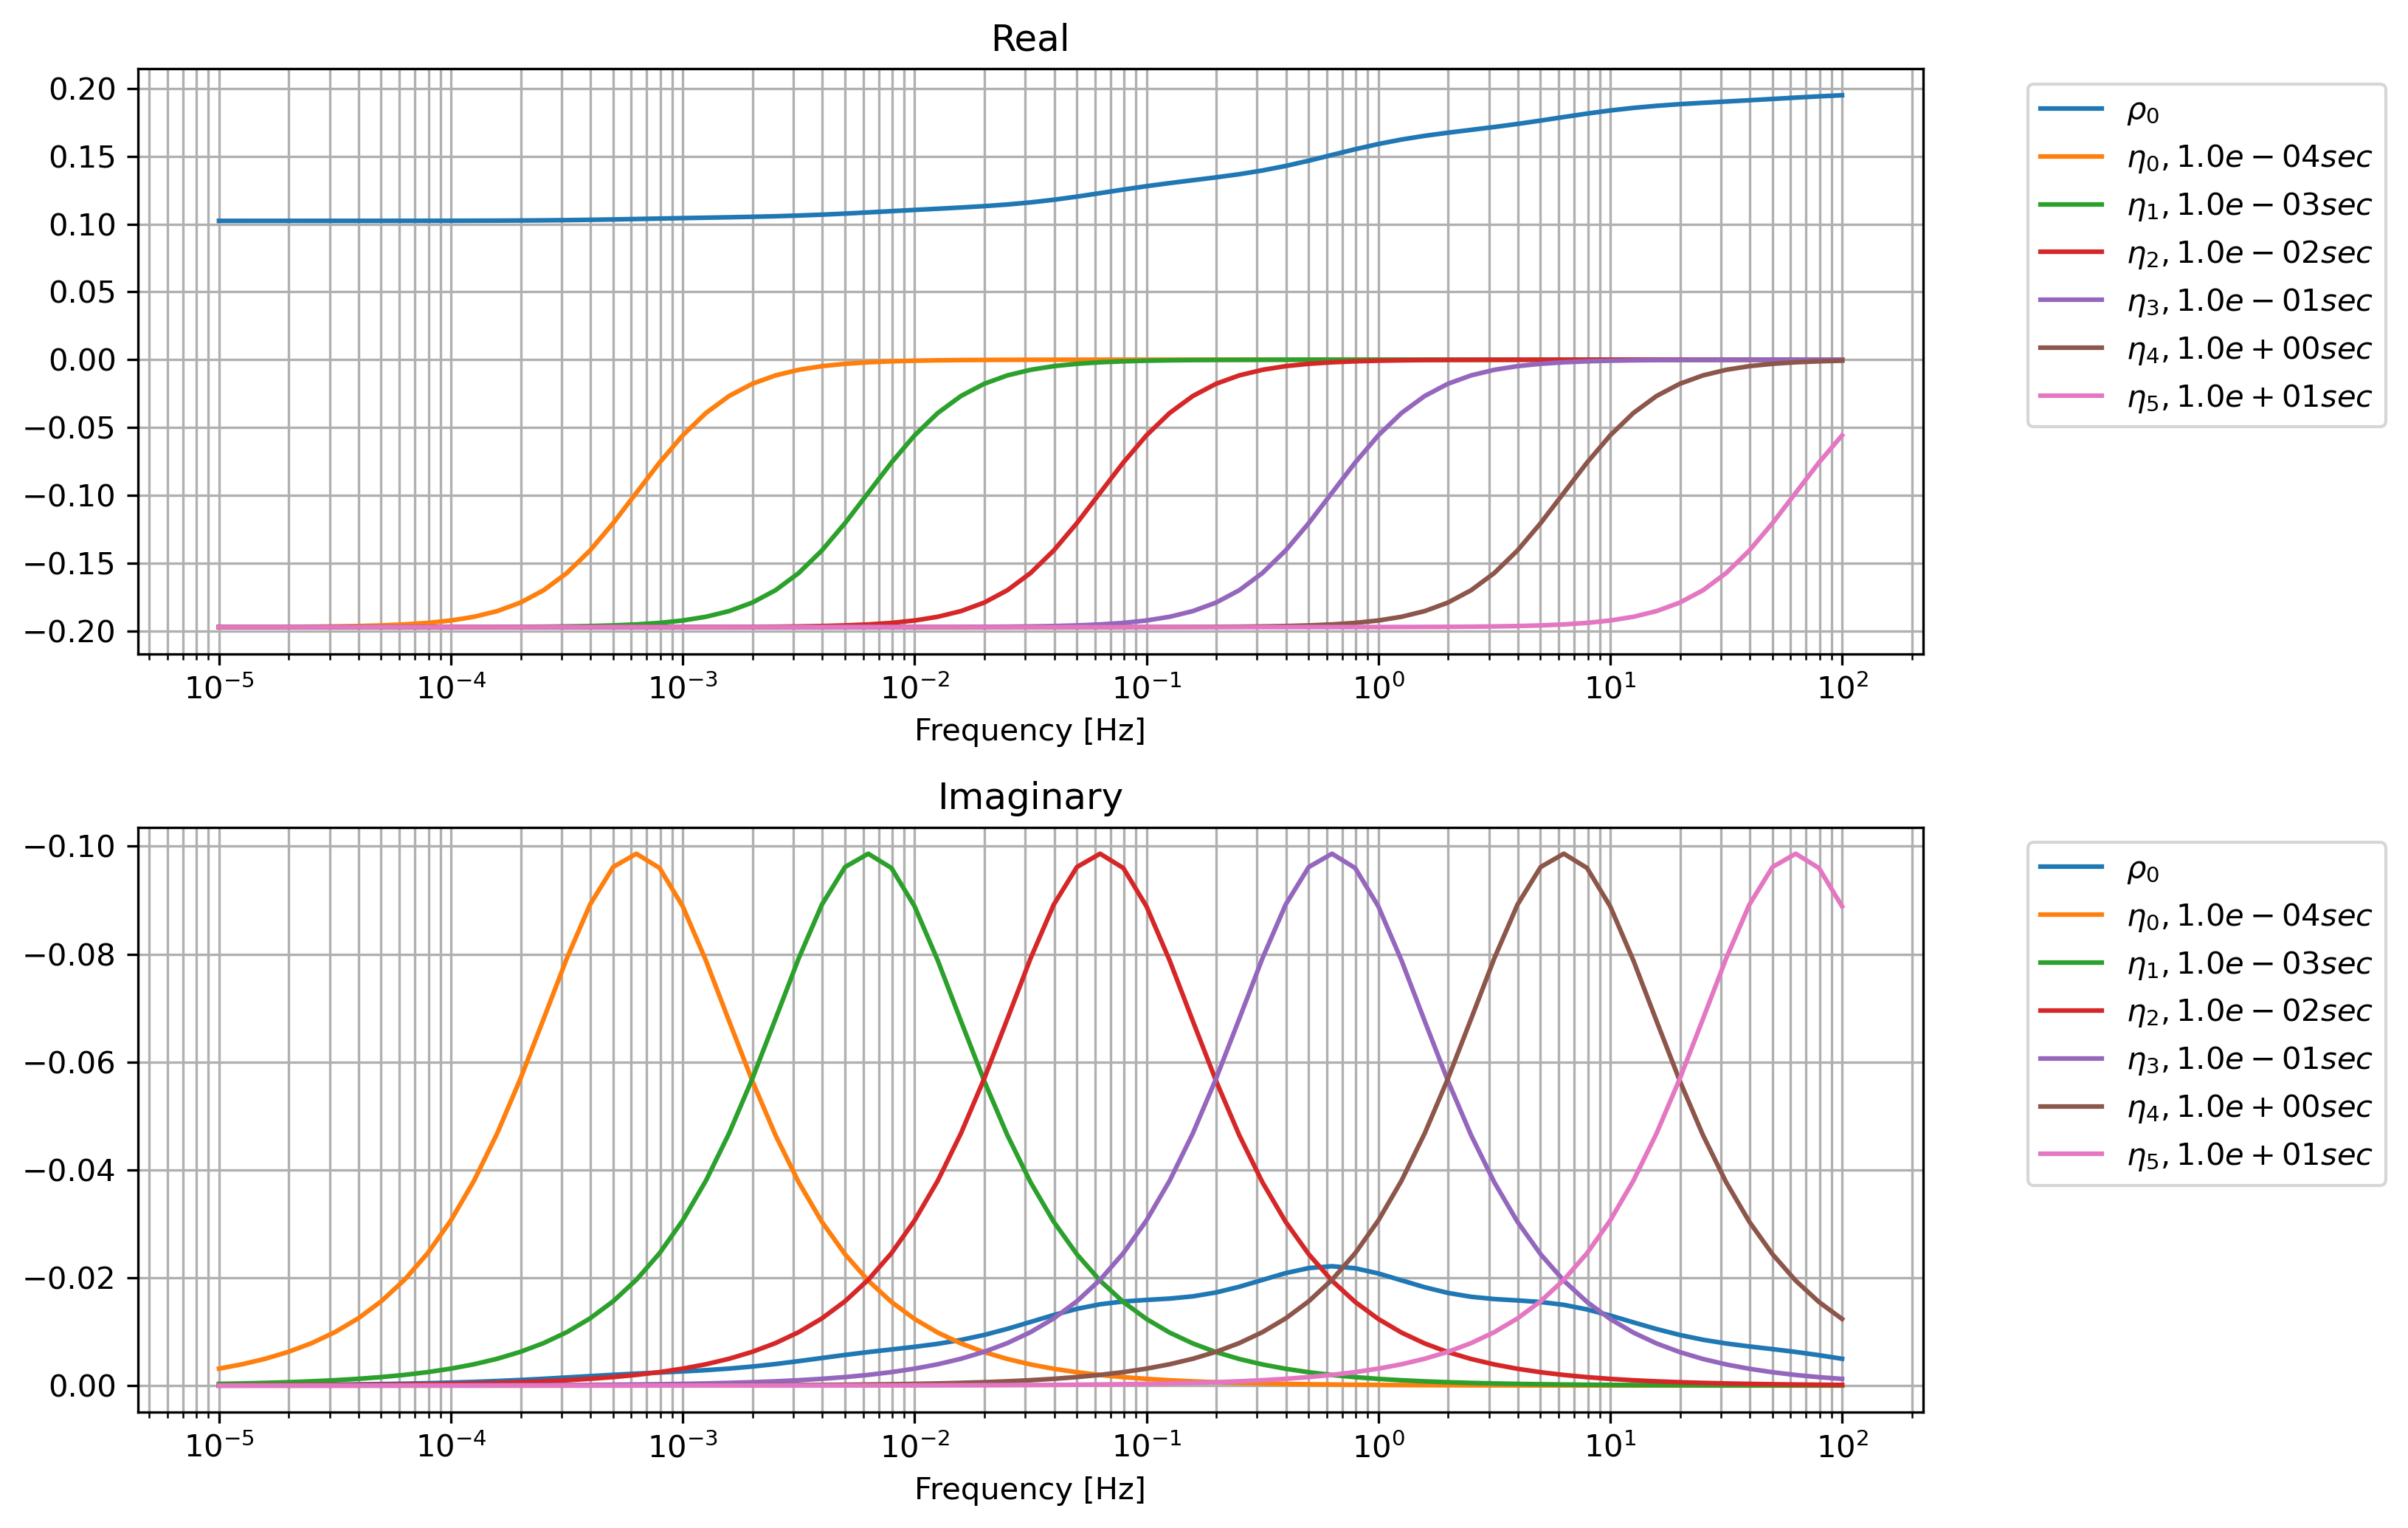

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(11, 7),dpi=300)

ax[0].semilogx(1./freq_plot, j_plot_real[:,0], color="C0", 
               label=r"$\rho_0$")
ax[1].semilogx(1./freq_plot, j_plot_imag[:,0], color="C0",
               label=r"$\rho_0$")
for i in range(ntau):
    ax[0].semilogx(1./freq_plot, j_plot_real[:,i+1], color=f"C{i+1}", 
                   label=f"$\eta_{i}, {taus[i]:.1e} sec$")
    ax[1].semilogx(1./freq_plot, j_plot_imag[:,i+1], color=f"C{i+1}",
                     label=f"$\eta_{i}, {taus[i]:.1e} sec$")
ax[1].invert_yaxis()

for a in ax:
        a.set_xlabel('Frequency [Hz]')
        a.grid(which='both')
        a.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
ax[0].set_title('Real')
ax[1].set_title('Imaginary')
plt.tight_layout()
plt.savefig("42_Debye_sum_sip_jacobian.jpg", dpi=300)

# Compare Singular Value of Jacobian

In [23]:
U_debye = []
S_debye=[]
S_debye_norm = []
V_debye=[]
for i in range(nref):
    IP_model = Debye_Sum_Ser_f(freq=freq, taus=taus_cmb[i])
    sim = InducedPolarizationSimulation(ip_model=IP_model, mode="sip")
    J_np = sim.J(models_rec[i]).detach().numpy()
    U, S, V = np.linalg.svd(J_np, full_matrices=False)
    U_debye.append(U)
    S_debye.append(S)
    s_norm = S/S.max()
    S_debye_norm.append(s_norm)
    V_debye.append(V)


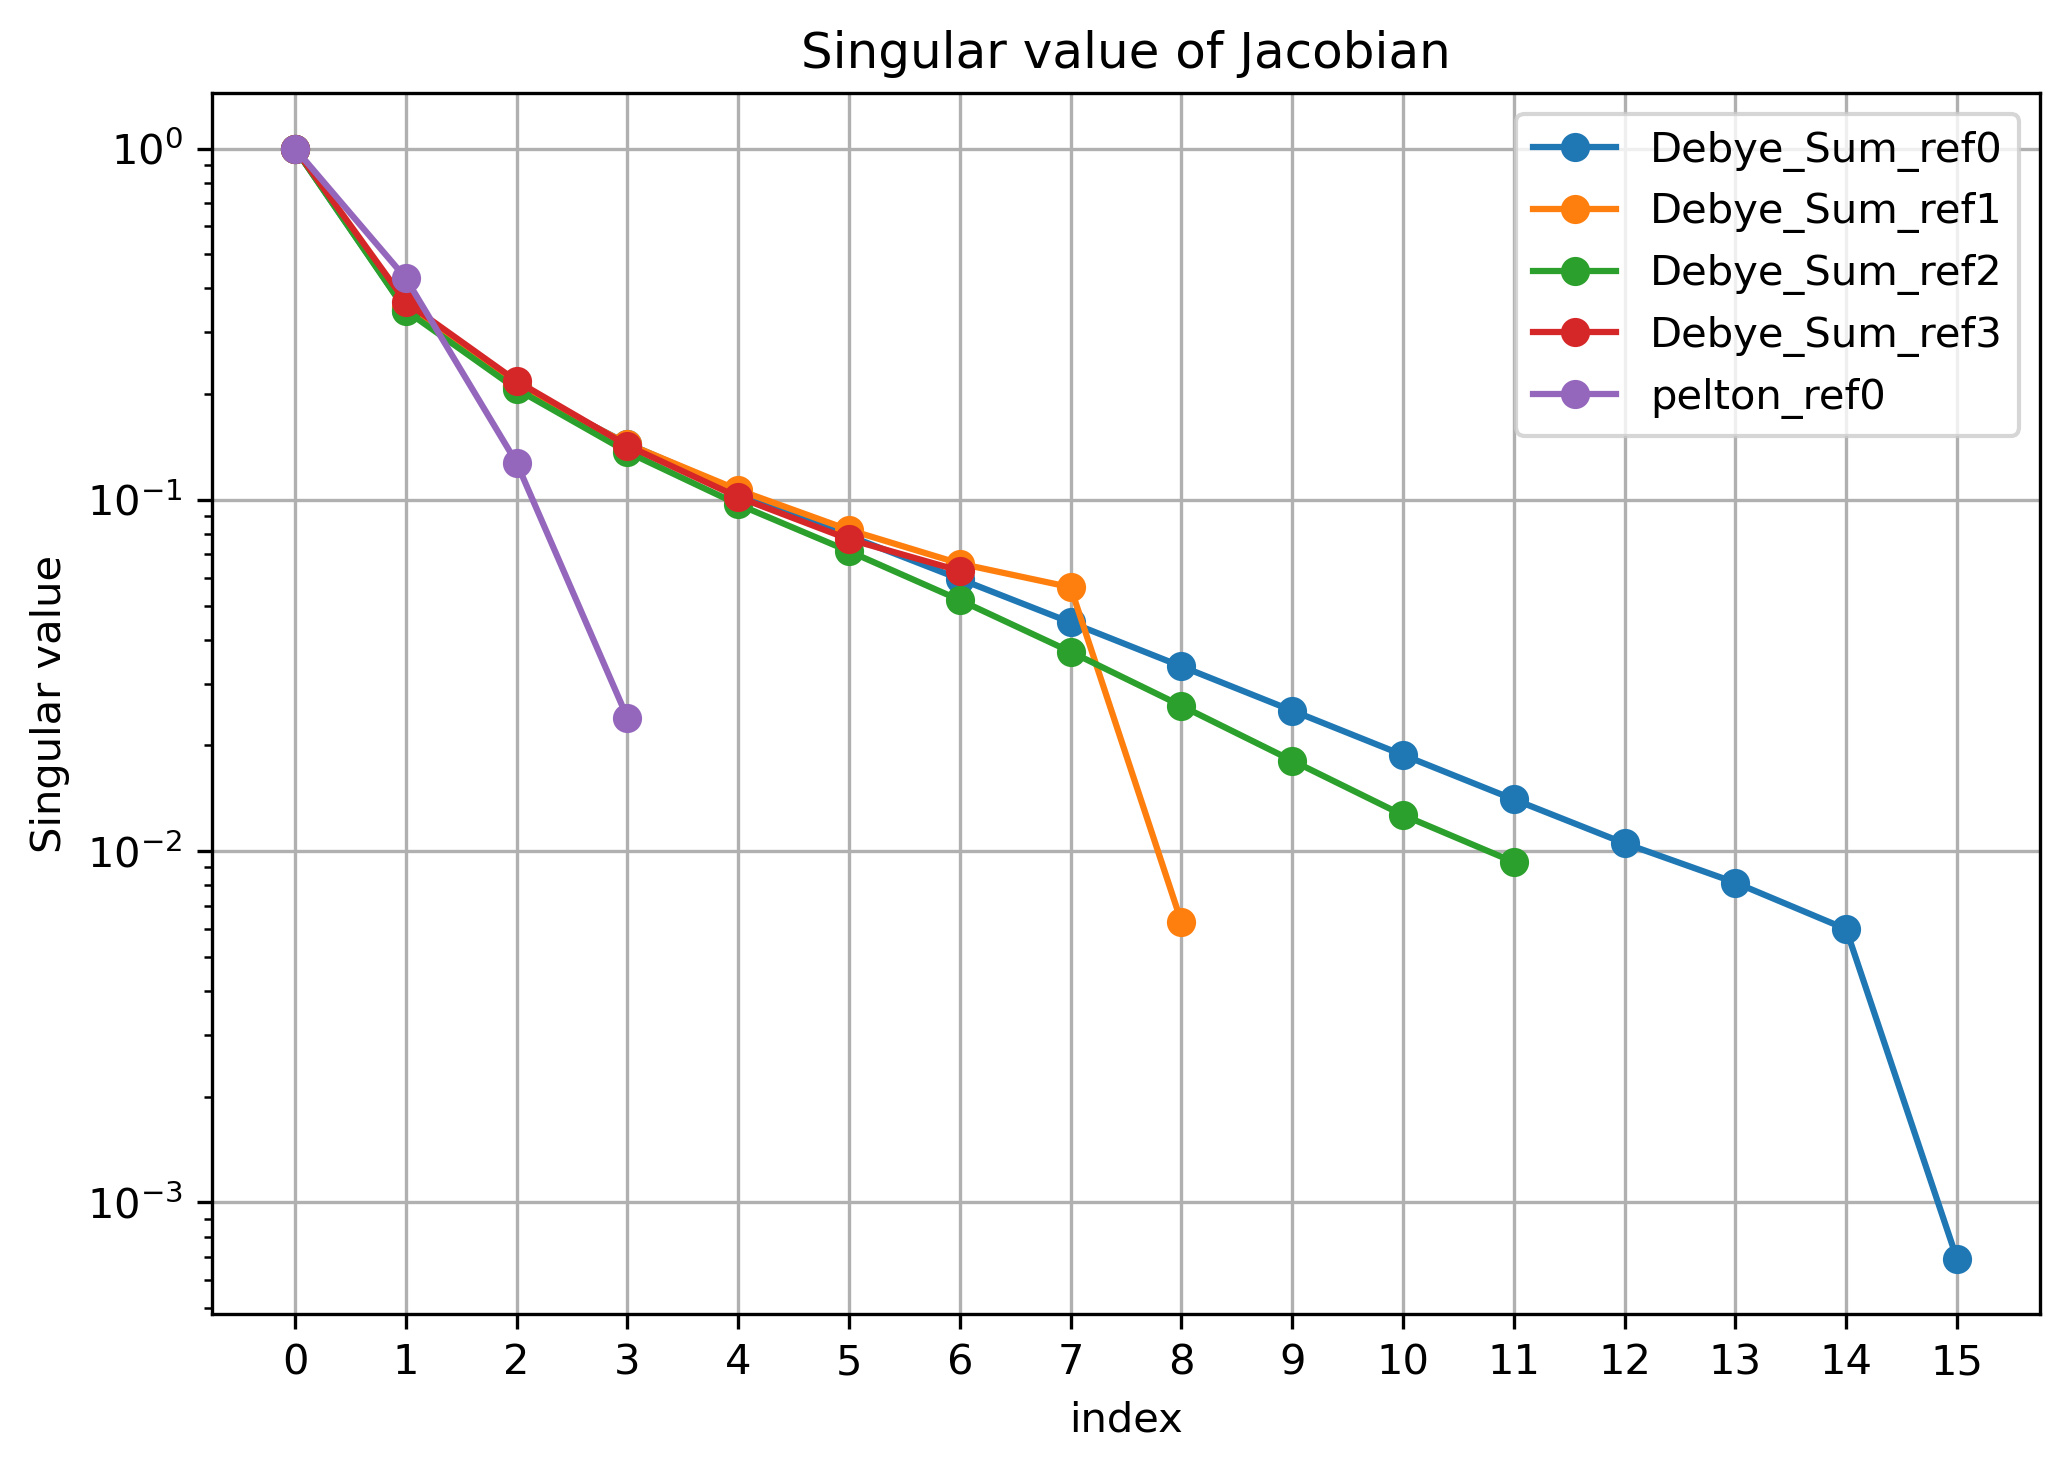

In [24]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=300)
for i in range(nref):
    ax.semilogy(S_debye_norm[i], label=f'Debye_Sum_ref{i}', marker="o")
i=0
ax.semilogy(S_pelton_norm[i], label=f'pelton_ref{i}', marker="o")
ax.set_xticks(range(max(ntau_cmb)+1))
ax.grid()
ax.legend()
ax.set_xlabel("index")
ax.set_ylabel("Singular value")
ax.set_title("Singular value of Jacobian")
plt.tight_layout()
plt.savefig("42_Debye_sum_sip_singular.jpg", dpi=300)

In [37]:
np.savez("42_SingularValue.npz", 
         Pelton= np.array(S_pelton_norm, dtype=object),
         Deby_Sum=np.array(S_debye_norm, dtype=object),
         taus_cmb=np.array(taus_cmb, dtype=object),
)

In [32]:
S_pelton_norm

[array([1.        , 0.42733264, 0.12748171, 0.02397781], dtype=float32),
 array([1.        , 0.42357808, 0.12706381, 0.02350496], dtype=float32),
 array([1.        , 0.4226249 , 0.12705714, 0.02337969], dtype=float32),
 array([1.        , 0.42338148, 0.12710065, 0.02347733], dtype=float32)]

In [33]:
S_debye_norm

[array([1.00000000e+00, 3.47752690e-01, 2.10197926e-01, 1.44616693e-01,
        1.05552346e-01, 7.89922476e-02, 5.95142655e-02, 4.47785594e-02,
        3.35754529e-02, 2.51249392e-02, 1.87835060e-02, 1.40418028e-02,
        1.05304178e-02, 8.13679956e-03, 6.00093836e-03, 6.92039437e-04],
       dtype=float32),
 array([1.        , 0.3535693 , 0.21068193, 0.14432912, 0.10672839,
        0.08213251, 0.06586017, 0.05639637, 0.00629496], dtype=float32),
 array([1.        , 0.34574753, 0.20658453, 0.13683373, 0.09701777,
        0.07140221, 0.05184374, 0.03694774, 0.02592361, 0.01810154,
        0.01266653, 0.00931436], dtype=float32),
 array([1.        , 0.36563054, 0.21782917, 0.14272577, 0.10180463,
        0.07722669, 0.06281349], dtype=float32)]

In [34]:
taus_cmb

[array([1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
        1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
        1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
        1.00000000e+01, 3.16227766e+01, 1.00000000e+02]),
 array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 array([1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
        1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
        1.00000000e+00, 3.16227766e+00, 1.00000000e+01]),
 array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])]